# Q1
## 1.1

Given the multi-object linear Gaussian Hidden Markov Model (MOHMM) for tracking $K$ interacting objects. Each object evolves in a 4-dimensional state space (position and velocity), and the overall system is modeled using Kronecker products to build block-diagonal matrices.

We have the HMM:
\begin{align*}
\pi_0(x_0) &= \mathcal{N}(x_0; m_0, P_0) \\
\tau(x_t | x_{t-1}) &= \mathcal{N}(x_t; A x_{t-1}, Q) \\
g(y_t | x_t) &= \mathcal{N}(y_t; H x_t, R)
\end{align*}

With params:
\begin{align*}
A &= \begin{bmatrix}
I_2 & \kappa I_2 \\
0_{2\times 2} & 0.99 I_2
\end{bmatrix}, \quad
H = I_4, \quad
Q = \begin{bmatrix}
\frac{\kappa^3}{3} I_2 & \frac{\kappa^2}{2} I_2 \\
\frac{\kappa^2}{2} I_2 & \kappa I_2
\end{bmatrix}, \quad
R = r I_4
\end{align*}

To scale this model to $K$ objects, we define four $4K \times 4K$ matrices:
\begin{align*}
\bar{A}_K = I_K \otimes A, \quad
\bar{Q}_K = I_K \otimes Q + L L^\top,, \quad
\bar{H}_K = I_K \otimes H, \quad
\bar{R}_K = I_K \otimes R
\end{align*}

where $L$ is a zero-mean Gaussian random matrix with standard deviation $\sigma_L$.

To generate data from this model, we do:

- Sample $x_0 \sim \mathcal{N}(m_0^{(K)}, P_0^{(K)})$
- For $t = 1$ to $T$:

    - Sample $x_t \sim \mathcal{N}(\bar{A}_K x_{t-1}, \bar{Q}_K)$
    - Sample $y_t \sim \mathcal{N}(\bar{H}_K x_t, \bar{R}_K)$
    


We implemented the above simulator and tested it for $K = 1, 2, 5$ objects. For each case, we plot the observed data $y_t$ and the first two dimensions of the true trajectories of each object.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

I2 = np.eye(2)
I4 = np.eye(4)

kappa=0.1
r = 0.1
A = np.block([
    [I2, kappa * I2],
    [np.zeros((2, 2)), 0.99 * I2]
])

Q = np.block([
    [(kappa**3 / 3) * I2, (kappa**2 / 2) * I2],
    [(kappa**2 / 2) * I2, kappa * I2]
])

H = I4
R = r * I4

# since Q_bar is random, we want to save it for each K
Q_ks = {}

def simulate_MOHMM(K, T=400, sigma_L=0.5, seed=42):
    if seed is not None:
        np.random.seed(seed)

    # Block-diagonal for K objects
    AK = np.kron(np.eye(K), A)
    QK = np.kron(np.eye(K), Q)
    HK = np.kron(np.eye(K), H)
    RK = np.kron(np.eye(K), R)

    dim = 4 * K

    # since Q_bar is random, we want to save it for each K
    L = np.random.normal(0, sigma_L, size=(dim, dim))
    Q_bar_K = QK + L @ L.T
    Q_ks[K] = Q_bar_K

    # same m0 for all K objects, size (4K, )
    m0 = np.tile(np.array([0, 0, -20, 20]), K)
    P0 = np.eye(dim)
    x = np.random.multivariate_normal(m0, P0)

    X = [x.copy()]
    Y = []

    for _ in range(T):
        x = np.random.multivariate_normal(AK @ x, Q_bar_K)
        y = np.random.multivariate_normal(HK @ x, RK)
        X.append(x.copy())
        Y.append(y.copy())

    X = np.array(X)  # shape: (T+1, 4K)
    Y = np.array(Y)  # shape: (T, 4K)
    return X, Y

def plot_trajectories(X_list, K_list):
    plt.figure(figsize=(5, 5))
    
    for X, K in zip(X_list, K_list):
        for k in range(K): # loop over objects
            pos_x = X[:, 4*k + 0]
            pos_y = X[:, 4*k + 1]
            label = f"K={K}, Obj {k+1}"
            plt.plot(pos_x, pos_y, label=label)
    
    plt.xlabel("Position X")
    plt.ylabel("Position Y")
    plt.title("True Trajectories of Objects (First Two Dimensions)")
    plt.legend(prop={'size': 6})
    plt.grid(True)
    plt.tight_layout()
    plt.show()



We simulate 

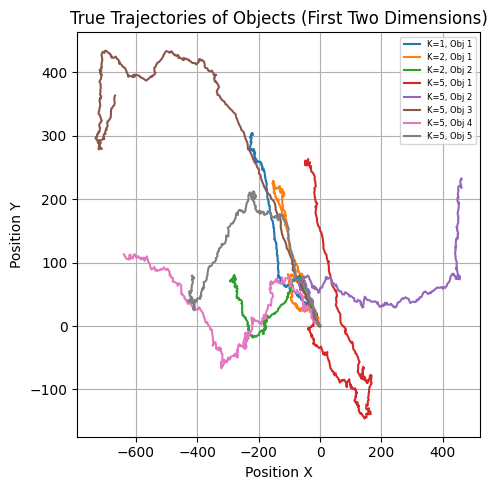

In [2]:
X1, Y1 = simulate_MOHMM(K=1, seed=42)
X2, Y2 = simulate_MOHMM(K=2, seed=42)
X5, Y5 = simulate_MOHMM(K=5, seed=42)

plot_trajectories([X1, X2, X5], [1, 2, 5])
# add observed y


## 1.2 Kalman Filter

### (a)

Given the HMM setup:
\begin{align*}
x_0 &\sim \mathcal{N}(m_0, P_0) \\
x_t \mid x_{t-1} &\sim \mathcal{N}(A x_{t-1}, Q) \\
y_t \mid x_t &\sim \mathcal{N}(H x_t, R)
\end{align*}

At each time step $t$, the Kalman filter computes the posterior distribution
$p(x_t \mid y_{1:t}) = \mathcal{N}(x_t; m_t, P_t)$

In this setting, we have:

- Input:
Starting point $ (m_0)_K \in R^{4K}, P_0=I_{4K} $, and the sequence of observations $ y_{1:T} $ for the specific T.

- Filtering:  
**For** $ n = 1, \dots, T $ **do**
    - Prediction step:
    \begin{align*}
    \hat{m}_t &= A_k m_{t-1} \\
    \hat{P}_t &= A_k P_{t-1} A_k^\top + Q
    \end{align*}

    - Update step:
    \begin{align*}
    K_t &= \hat{P}_t H^\top (H \hat{P}_t H^\top + R)^{-1} \\
    m_t &= \hat{m}_t + K_t (y_t - H \hat{m}_t) \\
    P_t &= (I - K_t H) \hat{P}_t
    \end{align*}

**End for**    

- Return $ m_{0:T}, P_{0:T}$

Here, $K_t$ is the Kalman gain matrix, and $m_t$, $P_t$ represent the posterior mean and covariance of the filtered state estimate at time $t$.



### (b)

In [3]:
def kalman_filter(Y, A, Q, H, R, m0, P0):
    T = len(Y)
    dim_x = len(m0) # 4K
    I = np.eye(dim_x)

    m = m0.copy()
    P = P0.copy()
    M_list = []
    P_list = []

    for t in range(T):
        # Prediction step
        m_pred = A @ m
        P_pred = A @ P @ A.T + Q

        # Update step
        y = Y[t]
        S = H @ P_pred @ H.T + R
        K = P_pred @ H.T @ np.linalg.inv(S)
        m = m_pred + K @ (y - H @ m_pred)
        P = (I - K @ H) @ P_pred

        M_list.append(m.copy())
        P_list.append(P.copy())

    return np.array(M_list), P_list


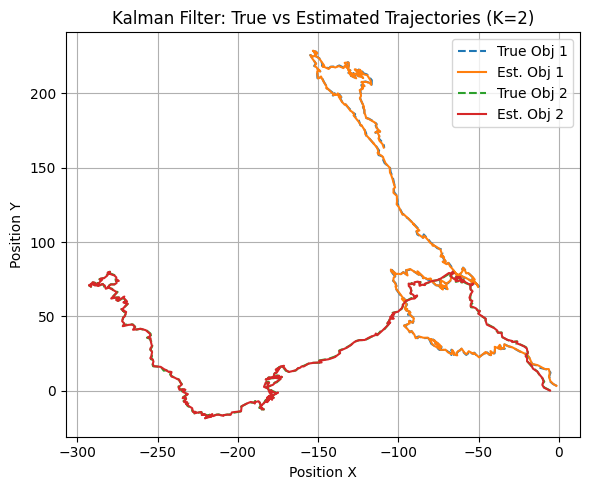

NMSE for K=2: 9.795175704546012e-06


In [4]:
def compute_nmse(true, est):
    """
    NMSE over sequence: true and est are shape (T+1, dim)
    """
    num = np.sum((true[1:] - est)**2)
    denom = np.sum(true[1:]**2)
    return num / denom

def run_kalman(X, Y, K, plot_trajectories = False):
    dim = 4 * K

    AK = np.kron(np.eye(K), A)
    QK = np.kron(np.eye(K), Q)
    HK = np.kron(np.eye(K), H)
    RK = np.kron(np.eye(K), R)

    # get stored Q_bar for this K
    Q_bar = Q_ks[K] 

    m0 = np.tile(np.array([0, 0, -20, 20]), K)
    P0 = np.eye(dim)

    # Step 2: Kalman filtering
    filtered_means, _ = kalman_filter(Y, AK, Q_bar, HK, RK, m0, P0)

    # Step 3: NMSE
    nmse = compute_nmse(X, filtered_means)

    # Step 4: Plot true vs estimated (position only)
    if plot_trajectories: 
        plt.figure(figsize=(6, 5))
        for k in range(K):
            idx_x = 4*k
            idx_y = 4*k + 1
            plt.plot(X[1:, idx_x], X[1:, idx_y], label=f"True Obj {k+1}", linestyle="--")
            plt.plot(filtered_means[:, idx_x], filtered_means[:, idx_y], label=f"Est. Obj {k+1}")
        plt.xlabel("Position X")
        plt.ylabel("Position Y")
        plt.title(f"Kalman Filter: True vs Estimated Trajectories (K={K})")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return nmse

# Run it on the simulated X2 and Y2
nmse = run_kalman(X2, Y2, K=2, plot_trajectories=True)
print(f"NMSE for K=2: {nmse}")


We have the visual plot for K = 2 for the sanity check. We can see that for the 2 objects simulated,
the trajectories of first 2 dims of both objects are almost perfectly estimated by the Kalman filter.

This agrees with the produced NMSE of 1e-05, which is really small.

Note when we simulated the data, we have saved the $\bar{Q_k}$ (which has a random component) in a dictionary.  So when we call `run_kalman`, we use the saved $\bar{Q_k}$, this ensures when we do kalman updates, we can use the same $\bar{Q_k}$ which generated the data by $\tau$

Now we run for K = 1,2,..,20

In [5]:
nmse_list = []
for K in range(1, 21):
    X, Y = simulate_MOHMM(K, seed=42)
    nmse = run_kalman(X, Y, K)
    # print(f"K={K}, NMSE={nmse:.4f}")
    nmse_list.append(nmse)
nmse_list = np.array(nmse_list)


In [6]:
state_dims = np.arange(1, 21) *4
state_dims

array([ 4,  8, 12, 16, 20, 24, 28, 32, 36, 40, 44, 48, 52, 56, 60, 64, 68,
       72, 76, 80])

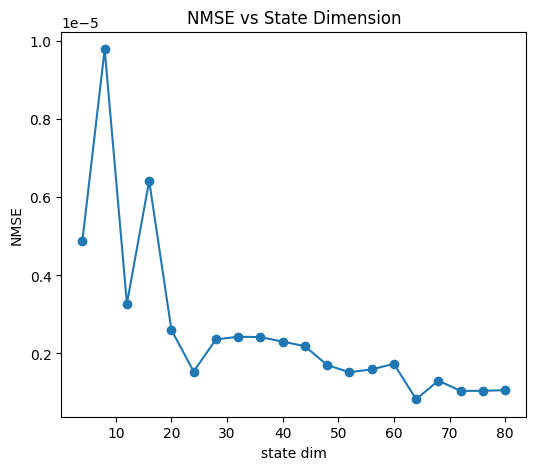

In [7]:
plt.figure(figsize=(6, 5))
plt.plot(state_dims, nmse_list, marker='o')
plt.xlabel("state dim")
plt.ylabel("NMSE")
plt.title("NMSE vs State Dimension")
plt.show()

We can notice that NMSE occilates initially on the level of 1e-5 for K < 10. 
As K gets larger, NMSE stables down and converges to around 5e-6. 
This is because NMSE is usually an average over all 4k state dimensions.
Having more objects means averaging over more terms, and random estimation errors (from process noise, measurement noise, etc.) tend to cancel each other out due to law of Large Numbers

## 1.3

### (a)

Like Kalman filter, we want to sequentially approximate 
the filtering distribution $p(x_t \mid y_{1:t})$ where

\begin{align*}
\pi_0(x_0) &= \mathcal{N}(x_0; m_0, P_0) \\
x_t \sim \tau(x_t | x_{t-1}) &= \mathcal{N}(x_t; A_k x_{t-1}, Q_k) \\
y_t \sim g(y_t | x_t) &= \mathcal{N}(y_t; H_k x_t, R_k)
\end{align*}

Where $x_t, y_t \in R^{4k}$ as before. 
Since we have the same setup as the lecture notes, we reference the BPF pesudocode below:

1. **Sample:**  
$ \bar{x}_0^{(i)} \sim q(x_0) \quad \text{for} \quad i = 1, \ldots, N. $

2. **Weight:**
For $ i = 1, \ldots, N $, 
- compute
$
W_0^{(i)} = \frac{\pi_0(\bar{x}_0^{(i)})}{q(\bar{x}_0^{(i)})},
$

- Compute the normalised weights 
$
w_0^{(i)} = \frac{W_0^{(i)}}{\sum_{j=1}^{N} W_0^{(j)}},
$

3. **Resample:**  
- Sample $ x_0^{(i)} \sim \sum_{i=1}^{N} w_0^{(i)} \delta_{\bar{x}_0^{(i)}}(\mathrm{d}x_0) $ for $ i = 1, \ldots, N $.

4. **for** $ n = 1, \ldots, T $ **do**

5. - **Sample:**  
$ \bar{x}_n^{(i)} \sim \tau_n(\cdot|x_{n-1}^{(i)}) \quad \text{for} \quad i = 1, \ldots, N. $

   - **Weight:**
    $
    W_n^{(i)} = g_n(y_n|\bar{x}_n^{(i)}),
    $
    for $ i = 1, \ldots, N $.

    - compute
    $
    w_n^{(i)} = \frac{W_n^{(i)}}{\sum_{j=1}^{N} W_n^{(j)}},
    $

    - **Resample:**  $ x_n^{(i)} \sim \sum_{i=1}^{N} w_n^{(i)} \delta_{\bar{x}_n^{(i)}}(\mathrm{d}x_n) $ for $ i = 1, \ldots, N $.

**end for**

**Return** the sequence of filtering distributions, either

$$
\pi_n^N(\mathrm{d}x_n|y_{1:n}) = \sum_{i=1}^{N} w_n^{(i)} \delta_{x_n^{(i)}}(\mathrm{d}x_n)
$$

or

$$
\pi_n^N(\mathrm{d}x_n|y_{1:n}) = \frac{1}{N} \sum_{i=1}^{N} \delta_{x_n^{(i)}}(\mathrm{d}x_n).
$$

Here we use $\pi_0$ as proposal, so that $W_0^{(i)} = 1$, and $w_0^{(i)} = \frac{1}{N}$ for all $i$

Therefore we don't need to do the first resample:
$ x_0^{(i)} \sim \sum_{i=1}^{N} w_0^{(i)} \delta_{\bar{x}_0^{(i)}}(\mathrm{d}x_0) $, as we already have a unweighted sample

### (b) Implement BPF

In [8]:
# first define log-likelihood for normal
def log_p(y, y_pred, R):
    '''y: (dim_y,) & y_pred: (N, dim_y), return (N,) array of likelihoods.'''
    dim_y = y.shape[0]
    diff = y_pred - y  # (N, dim_y)
    R_inv = np.linalg.inv(R)
    mahalanobis = np.sum(diff @ R_inv * diff, axis=1)  # (N,)
    log_det_R = np.linalg.slogdet(R)[1]  # More stable than np.log(np.linalg.det(R))
    
    log_likelihoods = -0.5 * (mahalanobis + dim_y * np.log(2 * np.pi) + log_det_R)
    return log_likelihoods


Note to sample $ \bar{x}_t^{(i)} \sim \tau = \mathcal{N}(x_t; A_k x_{t-1}, Q_k)$ for N times, 
we simply define a (N, 4k) vector: 
$x = (\bar{x}_{t-1}^{(1)}, \dots, \bar{x}_{t-1}^{(N)})$

Then the updated mean is given by $ (Ax^T)^T$, which is again a (N, 4k) vector,
where each row is $A_k \bar{x}_{t-1}^{(i)}$

Since we cannot pass in an array of N means into `np.random.normal`, 
we simulate (N, 4k)-shaped $\mathcal{N}(0, Q_k)$ noise, to be added to the updated mean

In [9]:
def bootstrap_particle_filter(Y, A, Q, H, R, m0, P0, N=500):
    T = len(Y)
    dim_x = len(m0) # 4K
    
    # Step 1: init particles
    x = np.random.multivariate_normal(m0, P0, size=N)  # Shape: (N, dim_x)
    
    particle_history = []

    for t in range(T):
        # Step 2: Propagation, sample from tau(x|xt-1) for N times
        # we vectorize by sampling N*dim_x noise, then add to the mean
        # note x is (N, dim_x) and A is (dim_x, dim_x), so Ax is given by Ax^T
        noise = np.random.multivariate_normal(np.zeros(dim_x), Q, size=N)
        x = (A @ x.T).T + noise  # Shape: (N, dim_x)
        
        # Step 3: Weight Update
        y = Y[t]
        y_pred = (H @ x.T).T  # Shape: (N, dim_y)
        
        # compute Normal(y, y_pred, R), shape (N,)
        diff = y_pred - y
        likelihoods = np.exp(-0.5 * np.sum(diff @ np.linalg.inv(R) * diff, axis=1))
        likelihoods /= np.sqrt((2 * np.pi)**len(y) * np.linalg.det(R))
        
        weights = likelihoods + 1e-300  # avoid numerical issues
        weights /= np.sum(weights)
        
        # Step 4: Resampling
        indices = np.random.choice(N, size=N, p=weights)
        x = x[indices]
        
        # Save x
        particle_history.append(x.copy())
        
    return particle_history

def run_bpf(X, Y, K, N=500, plot_trajectories=False):
    dim = 4 * K
    
    AK = np.kron(np.eye(K), A)
    QK = np.kron(np.eye(K), Q)
    HK = np.kron(np.eye(K), H)
    RK = np.kron(np.eye(K), R)

    # get stored Q_bar for this K
    Q_bar = Q_ks[K]

    m0 = np.tile(np.array([0, 0, -20, 20]), K)
    P0 = np.eye(dim)

    # Step 2: Particle Filtering
    particle_history = bootstrap_particle_filter(Y, AK, Q_bar, HK, RK, m0, P0, N)
    
    # Step 3: Estimate means
    filtered_means = np.array([x.mean(axis=0) for x in particle_history])
    
    # Step 4: NMSE
    nmse = compute_nmse(X, filtered_means)
    
    if plot_trajectories:
        plt.figure(figsize=(6, 5))
        for k in range(K):
            idx_x = 4*k
            idx_y = 4*k + 1
            plt.plot(X[1:, idx_x], X[1:, idx_y], label=f"True Obj {k+1}", linestyle="--")
            plt.plot(filtered_means[:, idx_x], filtered_means[:, idx_y], label=f"Est. Obj {k+1}")
        plt.xlabel("Position X")
        plt.ylabel("Position Y")
        plt.title(f"Bootstrap Particle Filter: True vs Estimated Trajectories (K={K})")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    
    return nmse


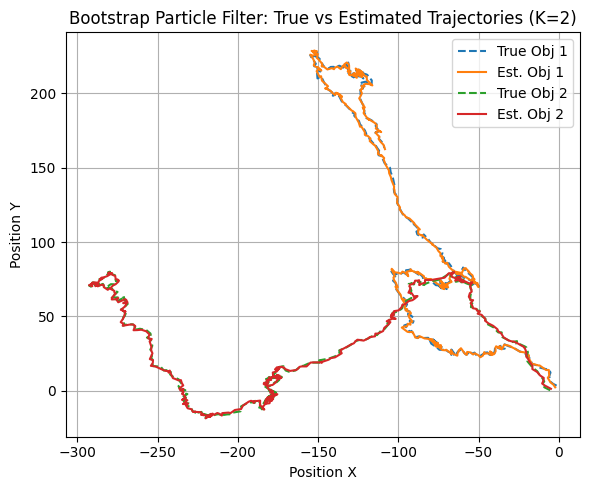

NMSE for BPF K=2: 6.293419567799077e-05


In [10]:
nmse_bpf = run_bpf(X2, Y2, K=2, plot_trajectories=True)
print(f"NMSE for BPF K=2: {nmse_bpf}")

Again we have the visual plot for K = 2 for the sanity check. Visually this looks just as good as the kalman filter plot. We can see that for the 2 objects simulated,
the trajectories of first 2 dims of both objects are almost perfectly estimated by the BPF.
This agrees with the produced NMSE of 6e-05, which is really small.

Now we run BPF for K = 1,2,..,20. Note when we call `run_bpf`, we have saved the $\bar{Q_k}$ in a dictionary, which has a random component. This ensures when we do BPF, we can sample using the same $\tau$ which generated the data.

The data can be generated again using `simulate_MOHMM`, since I have fixed the seed and tested this will generate the same data, and is pretty fast so I did not make an effort to save the data

In [11]:
nmse_bpf_list = []
for K in range(1, 21):
    X, Y = simulate_MOHMM(K, seed=42)
    nmse = run_bpf(X, Y, K)
    nmse_bpf_list.append(nmse)
nmse_bpf_list = np.array(nmse_bpf_list)

In [12]:
nmse_bpf_list

array([6.08342371e-06, 6.71323634e-05, 6.11864792e-05, 5.22814353e-01,
       1.17529517e+00, 5.15445617e-01, 5.73495761e-01, 1.09202687e+00,
       1.58558228e+00, 1.44661409e+00, 1.32302116e+00, 8.91565346e-01,
       1.04346014e+00, 1.42162380e+00, 1.47799228e+00, 1.11816329e+00,
       1.03641259e+00, 7.80673909e-01, 1.29972809e+00, 1.00495131e+00])

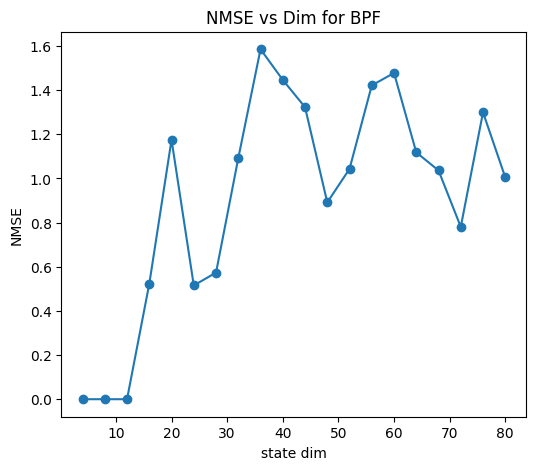

In [13]:
plt.figure(figsize=(6, 5))
plt.plot(state_dims, nmse_bpf_list, marker='o')
plt.xlabel("state dim")
plt.ylabel("NMSE")
plt.title("NMSE vs Dim for BPF")
plt.show()

### (c)

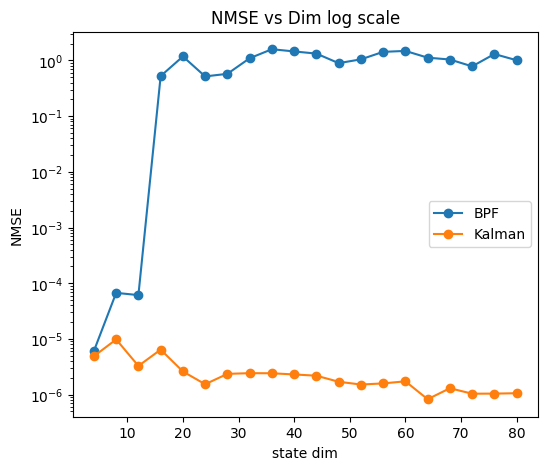

In [14]:
plt.figure(figsize=(6, 5))
plt.plot(state_dims, nmse_bpf_list, marker='o')
plt.plot(state_dims, nmse_list, marker='o')
plt.legend(["BPF", "Kalman"])
plt.yscale("log")
plt.xlabel("state dim")
plt.ylabel("NMSE")
plt.title("NMSE vs Dim log scale")
plt.show()

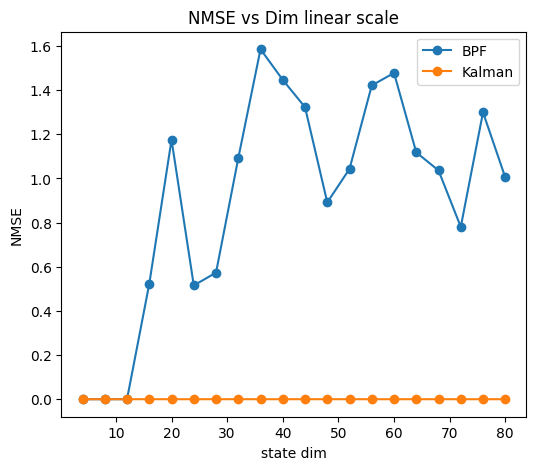

In [15]:
plt.figure(figsize=(6, 5))
plt.plot(state_dims, nmse_bpf_list, marker='o')
plt.plot(state_dims, nmse_list, marker='o')
plt.legend(["BPF", "Kalman"])
plt.xlabel("state dim")
plt.ylabel("NMSE")
plt.title("NMSE vs Dim linear scale")
plt.show()

### (d) 
we visually observe that the fourth datapoint of BPF goes above 0.5. To confirm this guess, we print:

In [16]:
nmse_bpf_list[:5]

array([6.08342371e-06, 6.71323634e-05, 6.11864792e-05, 5.22814353e-01,
       1.17529517e+00])

so K = 4 is smallest where BPF fails for N = 500

In [ ]:
nmse_bpf_k4 = []
M = 3
N_list = [100, 500, 1000, 5000, 10000]
X, Y = simulate_MOHMM(K=4, seed=42)
for n in N_list:
    nmse = 0
    for _ in range(M): # run BPF M times
        nmse += run_bpf(X, Y, K=4, N = n)
    nmse /= M
    nmse_bpf_k4.append(nmse)
# nmse_bpf_k4 = np.array(nmse_bpf_k4)
nmse_bpf_k4

[3.3619802939884806,
 0.41871909599396534,
 0.26946238613747364,
 0.00015690732757633367,
 0.00012718256912042637]

Text(0.5, 1.0, 'NMSE vs Number of Particles for K=4')

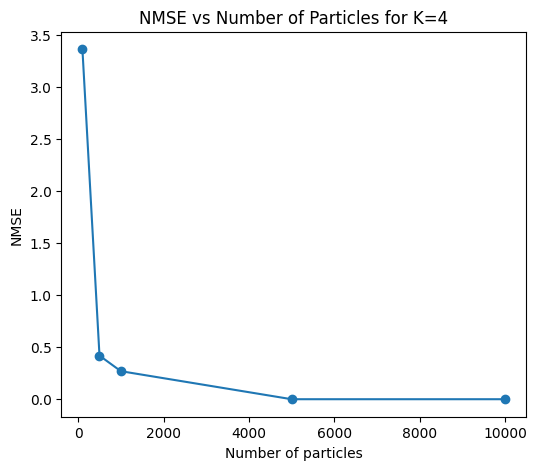

In [20]:
plt.figure(figsize=(6, 5))
plt.plot(N_list, nmse_bpf_k4, marker='o')
plt.xlabel("Number of particles")
plt.ylabel("NMSE")
plt.title("NMSE vs Number of Particles for K=4")